# Themes with highest business oppurtunity


===== IDENTIFYING THEMES WITH HIGH BUSINESS OPPORTUNITY (IMPROVED) =====
    claim_id  opportunity_score  hidden_gem
0          8           0.682815       False
15       430           0.615154        True
13       227           0.482322       False
12       193           0.351165        True
1         39           0.333681        True
10       163           0.328222        True
11       187           0.313371       False
2         40           0.306222        True
8        152           0.265232        True
17       438           0.245082       False


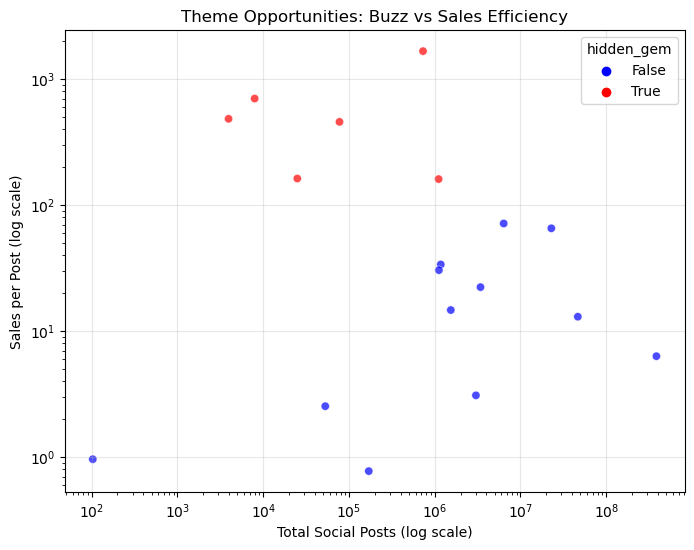

In [3]:

import os
import os.path as op
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

processed_folder = op.join('data', 'processed')
model_output_dir = op.join('models')
final_df = pd.read_parquet(op.join(processed_folder, 'final_model_data.parquet'))

print("\n===== IDENTIFYING THEMES WITH HIGH BUSINESS OPPORTUNITY (IMPROVED) =====")

#  Aggregate sales metrics by theme
theme_sales = final_df.groupby('claim_id')['sales_dollars_value'].agg(['sum', 'mean', 'count']).reset_index()
theme_sales.columns = ['claim_id', 'total_sales', 'avg_sales', 'transaction_count']

# Aggregate total social posts by theme
social_by_theme = final_df.groupby('claim_id')['total_post'].sum().reset_index()
social_by_theme.columns = ['claim_id', 'total_posts']

#  Merge sales and social data
theme_analysis = pd.merge(theme_sales, social_by_theme, on='claim_id', how='left')

#  Handle zero posts to avoid division by zero
theme_analysis['total_posts'] = theme_analysis['total_posts'].replace(0, 0.1)

#  Calculate sales per post
theme_analysis['sales_per_post'] = theme_analysis['total_sales'] / theme_analysis['total_posts']

# Log-transform 'sales_per_post' to reduce skewness
theme_analysis['sales_per_post_log'] = np.log1p(theme_analysis['sales_per_post'])

# Normalize total_sales, transaction_count, and sales_per_post_log
scaler = MinMaxScaler()
theme_analysis[['total_sales_scaled', 'transaction_count_scaled', 'sales_per_post_scaled']] = scaler.fit_transform(
    theme_analysis[['total_sales', 'transaction_count', 'sales_per_post_log']]
)

#  Compute opportunity score (weighted)
theme_analysis['opportunity_score'] = (
    0.4 * theme_analysis['total_sales_scaled'] +
    0.4 * theme_analysis['sales_per_post_scaled'] +
    0.2 * theme_analysis['transaction_count_scaled']
)

#  Detect hidden gems (low total posts, high sales efficiency)
median_posts = theme_analysis['total_posts'].median()
median_sales_per_post = theme_analysis['sales_per_post'].median()
theme_analysis['hidden_gem'] = (
    (theme_analysis['total_posts'] < median_posts) &
    (theme_analysis['sales_per_post'] > median_sales_per_post)
)

#  Sort by opportunity score (highest first)
theme_analysis = theme_analysis.sort_values('opportunity_score', ascending=False)

# Display top themes
print(theme_analysis[['claim_id', 'opportunity_score', 'hidden_gem']].head(10))


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=theme_analysis,
    x='total_posts', y='sales_per_post',
    hue='hidden_gem',
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Social Posts (log scale)')
plt.ylabel('Sales per Post (log scale)')
plt.title('Theme Opportunities: Buzz vs Sales Efficiency')
plt.grid(True, alpha=0.3)
plt.show()



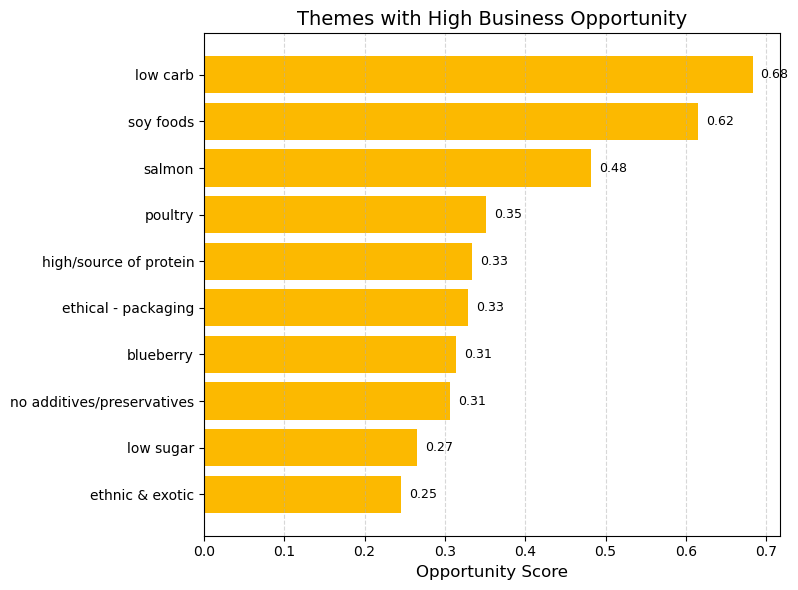

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Data you provided
theme_summary = pd.DataFrame({
    'claim_id': [8, 430, 227, 193, 39, 163, 187, 40, 152, 438],
    'opportunity_score': [0.682815, 0.615154, 0.482322, 0.351165, 0.333681, 
                           0.328222, 0.313371, 0.306222, 0.265232, 0.245082],
    'hidden_gem': [False, True, False, True, True, True, False, True, True, False]
})

# Load the raw data
cleaned_folder = op.join('data', 'cleaned')
theme_list_df = pd.read_parquet(op.join(cleaned_folder, 'theme_list.parquet'))
theme_product_df = pd.read_parquet(op.join(cleaned_folder, 'theme_product_list.parquet'))
social_media_df = pd.read_parquet(op.join(cleaned_folder, 'social_media_data.parquet'))


# Assuming theme_list_df has 'claim_id' and 'claim name' columns
# For example, theme_list_df might look like this:
theme_list_df = pd.read_parquet(op.join(cleaned_folder, 'theme_list.parquet'))

# Merge theme names from theme_list_df
theme_summary = theme_summary.merge(theme_list_df[['claim_id', 'claim name']], on='claim_id', how='left')

# Plot
plt.figure(figsize=(8,6))
bars = plt.barh(
    theme_summary['claim name'],  # Use 'claim name' for the y-axis
    theme_summary['opportunity_score'],
    color='#fcb900'
)

plt.xlabel('Opportunity Score', fontsize=12)
plt.title('Themes with High Business Opportunity', fontsize=14)
plt.gca().invert_yaxis()  # Highest score at top
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Optional: Annotate scores next to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va='center', fontsize=9)

plt.show()
